<a href="https://colab.research.google.com/github/osgeokr/GEE-PAM-Book/blob/main/cartoee_Google_Earth_Engine_%EA%B2%B0%EA%B3%BC%EB%A5%BC_%EC%9D%B8%EC%87%84%EC%9A%A9_%EC%A7%80%EB%8F%84%EB%A1%9C_%EC%83%9D%EC%84%B1%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cartoee: Google Earth Engine 결과를 인쇄용 지도로 생성하기

cartoee는 Cartopy를 사용하여 Google Earth Engine 결과를 인쇄용 지도(publication quality map)로 만들 수 있는 Python 패키지입니다. GEE 처리 결과를 별도 다운로드 과정 없이 빠르게 시각화할 수 있기 때문에 보고서나 논문을 작성할 때 매우 유용한 도구입니다.

## cartoee 설치

[PROJ](https://proj.org/en/9.4/install.html)와 [GEOS](https://libgeos.org/)의 사전 설치하고, 이어서 [cartopy](https://pypi.org/project/Cartopy/)를 설치합니다.

In [ ]:
# PROJ와 GEOS 설치
!apt-get install -qq libproj-dev proj-bin
!apt-get install -qq libgeos-dev

# Cartopy 설치
!pip install -q -U cartopy

이제 `from geemap import cartoee`를 통해 cartoee를 호출할 수 있습니다.

In [ ]:
import ee
import geemap
import matplotlib.pyplot as plt
from geemap import cartoee
from google.colab import files

# Earth Engine 인증
ee.Authenticate()

# Earth Engine 초기화
ee.Initialize(project='ee-foss4g')

## 공간 데이터 출력

'cartoee'를 사용해 인쇄용 지도를 만들어 보겠습니다. 여기서는 변산반도국립공원을 범위로 선택해 봅니다. 국립공원 경계는 WDPA에서 ID로 호출할 수 있습니다.

In [24]:
# WDPA 데이터셋 불러오기
wdpa = ee.FeatureCollection("WCMC/WDPA/current/polygons")

wdpa_id = 30712 # 해당 ID를 가진 WDPA 경계 선택
protected_area = wdpa.filter(ee.Filter.eq('WDPAID', wdpa_id))

# 지도 너비, 높이, 기본 지도 설정
m = geemap.Map(width="800px", height="500px", basemap='Esri.WorldImagery')
m.addLayer(protected_area, {'color': 'green'}, "National Park") # 레이어 추가
m.centerObject(protected_area, 12) # 지도의 중심 설정
m # 지도 객체 출력

Map(center=[35.64739890217585, 126.5763703325834], controls=(WidgetControl(options=['position', 'transparent_b…

인쇄용 지도를 만들기 위해서는 내가 원하는 지도 범위 `region`을 정의해야 합니다. FeatureCollection으로부터 일정 거리 버퍼를 추가한 지오메트리의 바운딩 박스를 추출해 봅니다.

In [26]:
def get_region(feature_collection, buffer_distance):
    # FeatureCollection의 지오메트리를 가져온 후 버퍼 추가
    buffered_geometry = feature_collection.geometry().buffer(buffer_distance)

    # 버퍼를 추가한 지오메트리의 바운딩 박스 추출
    bounds = buffered_geometry.bounds().getInfo()['coordinates'][0]

    # [동쪽 경계, 남쪽 경계, 서쪽 경계, 북쪽 경계] 형태로 정리
    region = [bounds[2][0], bounds[1][1], bounds[0][0], bounds[3][1]]

    return region

# 바운딩 박스 출력
region = get_region(protected_area, 4000)
print(region)

[126.71719579078756, 35.544306499389954, 126.40984978391168, 35.744137755479315]


이제 해당 `region` 범위를 기준으로 지리데이터를 인쇄용 지도로 출력해 보겠습니다. 선택한 이미지는 SRTM DEM입니다.

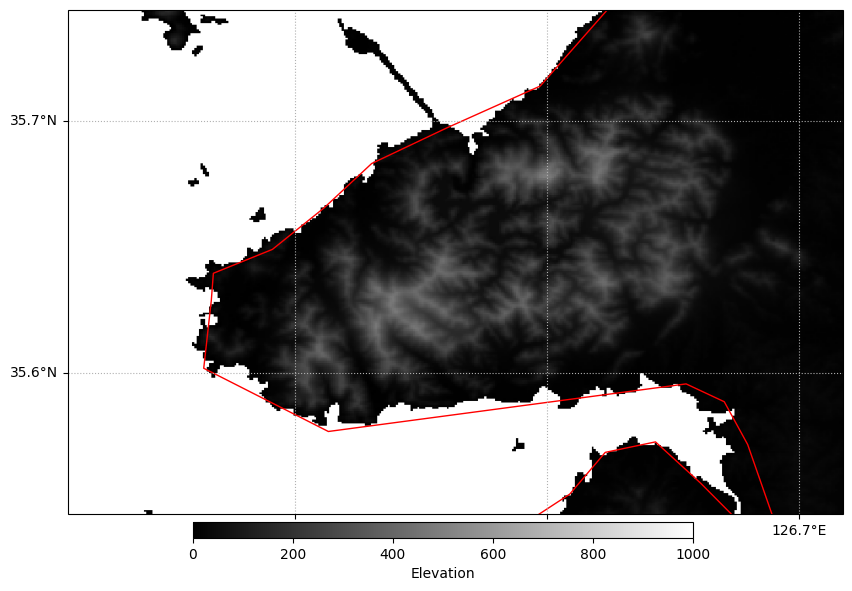

In [27]:
srtm = ee.Image("CGIAR/SRTM90_V4")

vis = {"min": 0, "max": 1000}

fig = plt.figure(figsize=(10, 8))
ax = cartoee.get_map(srtm, region=region, vis_params=vis)

cartoee.add_colorbar(ax, vis, loc="bottom", label="Elevation", orientation="horizontal")
cartoee.add_gridlines(ax, interval=[0.1, 0.1], linestyle=":")
ax.coastlines(color="red")

plt.show()

연습을 위해 컬러 바와 격자 선, 제목 설정 등을 조정해 봅니다.

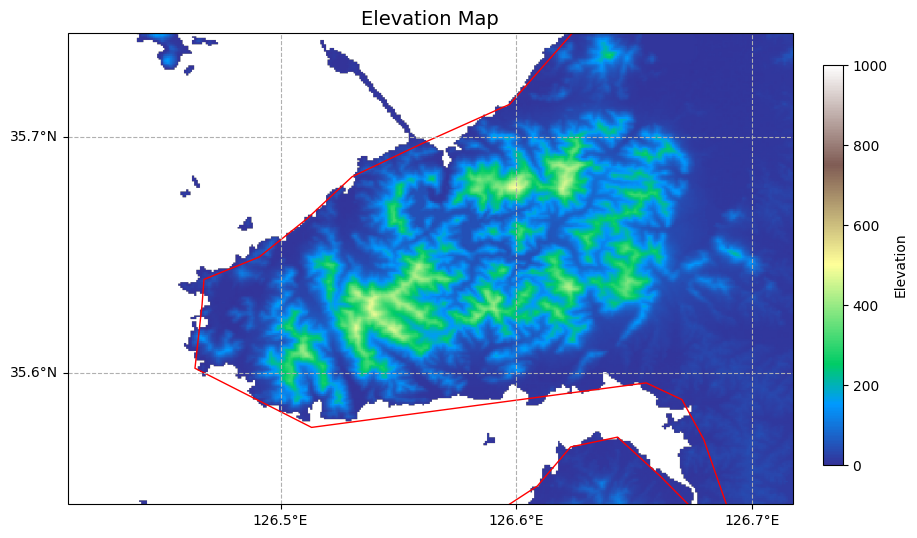

In [28]:
fig = plt.figure(figsize=(10, 8))
ax = cartoee.get_map(srtm, region=region, vis_params=vis, cmap="terrain")

cartoee.add_colorbar(
    ax, vis, cmap="terrain", loc="right", label="Elevation", orientation="vertical"
)
cartoee.add_gridlines(ax, interval=[0.1, 0.1], linestyle="--")

ax.set_title(label="Elevation Map", fontsize=14)
ax.coastlines(color="red")

plt.show()

## 위성 이미지 출력

이번에는 위성 이미지를 출력해 보겠습니다. 원하는 기간 내에서 Landsat 9호 이미지를 검색한 후, 구름피복이 가장 적은 첫번째 이미지를 반사율을 적용해 출력해 봅니다.

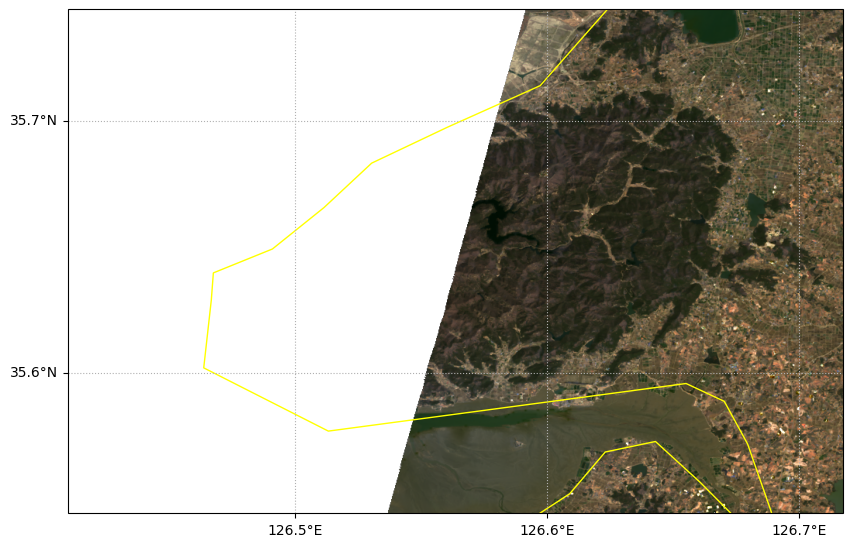

In [29]:
# Landsat 9호 이미지 검색
start_date = "2022-01-01"
end_date = "2022-12-31"

image_collection = (
    ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")
    .filterDate(start_date, end_date)
    .filterBounds(ee.Geometry.Rectangle(region))
)

# 구름 피복이 가장 낮은 이미지
image = image_collection.sort('CLOUD_COVER').first()
scaled_image = image.select('SR_B.').multiply(0.0000275).add(-0.2)

vis = {
    'bands': ['SR_B4', 'SR_B3', 'SR_B2'],
    'min': 0.0,
    'max': 0.3,
}

fig = plt.figure(figsize=(10, 8))
ax = cartoee.get_map(scaled_image, region=region, vis_params=vis)

cartoee.add_gridlines(ax, interval=0.1, linestyle=":")
ax.coastlines(color="yellow")

plt.show()

아쉽게도 변산반국립공원에 대한 위성 이미지가 절반만 표시되었습니다. Path와 Row를 기반으로 다른 범위의 Landsat 이미지를 선택해주는 게 좋겠습니다. 그렇다면 현재 보이는 위성 이미의 Path와 Row를 확인해 봐야겠죠?! 해당 코드는 아래와 같습니다.

In [30]:
# 이미지의 메타데이터에서 Path와 Row 정보 추출
path = image.get('WRS_PATH').getInfo()
row = image.get('WRS_ROW').getInfo()

print(f'Path: {path}, Row: {row}')

Path: 115, Row: 35


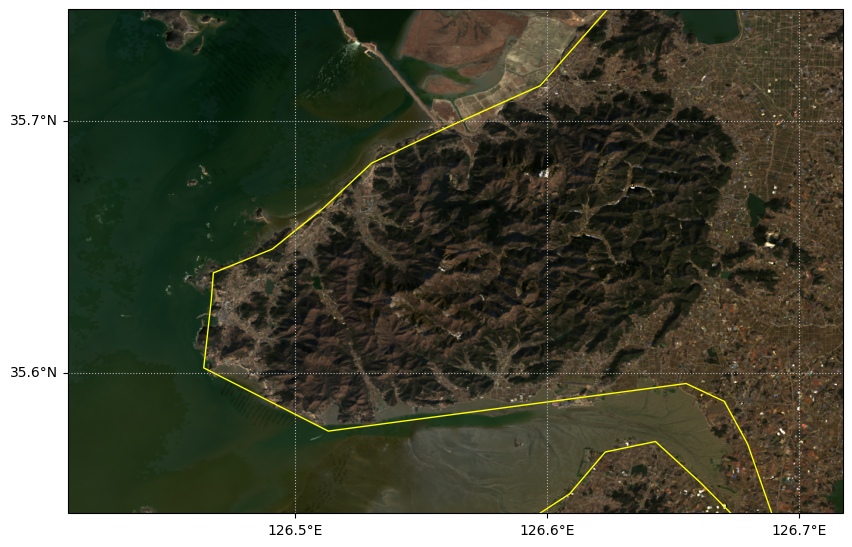

In [31]:
# Landsat 9호 이미지 검색

start_date = "2022-01-01"
end_date = "2022-12-31"

image = (
    ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")
    .filterDate(start_date, end_date)
    .filterBounds(ee.Geometry.Rectangle(region))
    .filter(ee.Filter.eq('WRS_PATH', 116))
    .filter(ee.Filter.eq('WRS_ROW', 35))
    .sort('CLOUD_COVER')
    .first()
)
scaled_image = image.select('SR_B.').multiply(0.0000275).add(-0.2)

fig = plt.figure(figsize=(10, 8))
ax = cartoee.get_map(scaled_image, region=region, vis_params=vis)

cartoee.add_gridlines(ax, interval=0.1, linestyle=":")
ax.coastlines(color="yellow")

plt.show()

원하는 범위에 위성 이미지를 표출하는데 2장 이상이 필요하다면, 아래 코드와 같이 모자이크를 통해 작업할 수 있습니다. 여기서는 밴드 조합도 Color Infrared (CIR)로 변경해 봤습니다.

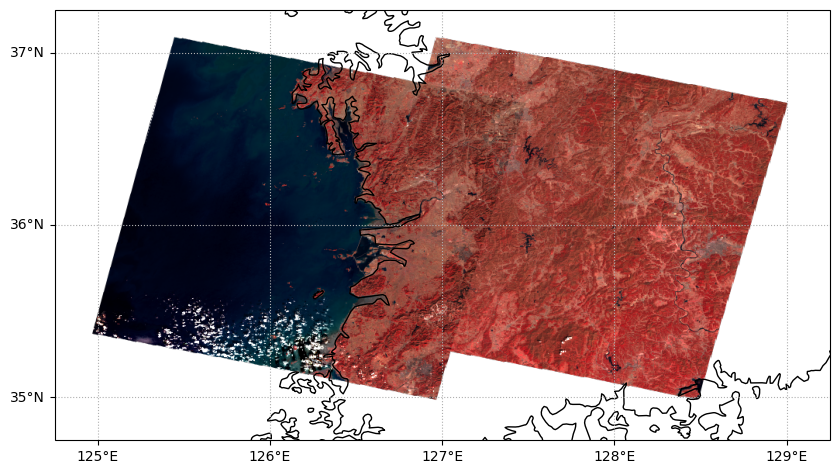

In [32]:
start_date = "2022-01-01"
end_date = "2022-12-31"

image_collection_114_35 = (
    ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")
    .filterDate(start_date, end_date)
    .filter(ee.Filter.eq('WRS_PATH', 115))
    .filter(ee.Filter.eq('WRS_ROW', 35))
    .sort('CLOUD_COVER')
    .first()
)
image_collection_115_35 = (
    ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")
    .filterDate(start_date, end_date)
    .filter(ee.Filter.eq('WRS_PATH', 116))
    .filter(ee.Filter.eq('WRS_ROW', 35))
    .sort('CLOUD_COVER')
    .first()
)

image_collection = ee.ImageCollection([image_collection_114_35, image_collection_115_35])
image = image_collection.mosaic()
scaled_image = image.select('SR_B.').multiply(0.0000275).add(-0.2)

vis = {
    'bands': ['SR_B5', 'SR_B4', 'SR_B3'],
    'min': 0.0,
    'max': 0.3,
}

fig = plt.figure(figsize=(10, 8))
ax = cartoee.get_map(scaled_image, region=[129.25, 34.75, 124.75, 37.25], vis_params=vis)

cartoee.add_gridlines(ax, interval=1, linestyle=":")
ax.coastlines(color="black")

plt.show()

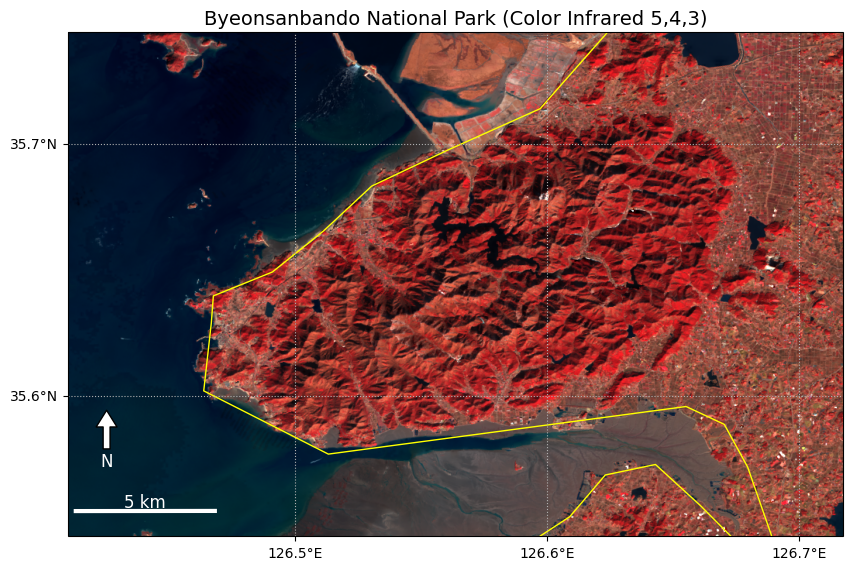

In [ ]:
# Landsat 9호 이미지 검색

start_date = "2022-01-01"
end_date = "2022-12-31"

image = (
    ee.ImageCollection("LANDSAT/LC09/C02/T1_L2")
    .filterDate(start_date, end_date)
    .filterBounds(ee.Geometry.Rectangle(region))
    .filter(ee.Filter.eq('WRS_PATH', 116))
    .filter(ee.Filter.eq('WRS_ROW', 35))
    .sort('CLOUD_COVER')
    .first()
)
scaled_image = image.select('SR_B.').multiply(0.0000275).add(-0.2)

fig = plt.figure(figsize=(10, 8))
ax = cartoee.get_map(scaled_image, region=region, vis_params=vis)

cartoee.add_gridlines(ax, interval=0.1, linestyle=":")
ax.coastlines(color="yellow")

# 북쪽 화살표
cartoee.add_north_arrow(
    ax, text="N", xy=(0.05, 0.25), text_color="white", arrow_color="white", fontsize=12
)
# 축척 바
cartoee.add_scale_bar_lite(
    ax, length=5, xy=(0.1, 0.05), color="white", unit="km", fontsize=12
)
ax.set_title(label="Byeonsanbando National Park (Color Infrared 5,4,3)", fontsize=14)

plt.show()